# Imports, funciones y globals

In [4]:
import json
import pandas as pd
import geopandas as gpd
import glob
import os
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, QuantileTransformer, OneHotEncoder, KBinsDiscretizer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from joblib import dump, load

dir_datos = 'D:/datos/ecobici/status_estaciones'

%matplotlib inline

## Funciones

In [2]:
# Convierte a DF
def json_to_df(jsonfile):
    with open(f'{dir_datos}/{jsonfile}', 'r') as f:
        data = json.load(f)
        df = pd.DataFrame(data['uso']).assign(fecha=jsonfile[:-5], **data['meta'])
        variables = ['id', 'name', 'bikes', 'slots', 'fecha', 'year', 'mes', 'dia', 'hora', 'minuto', 'nombre_dia']
        return df.filter(variables)

def evaluacion_resultados(modelo, x_test, y_test):
    y_true = y_test
    y_pred = modelo.predict(x_test)
    y_pred_red = np.int0(y_pred)
    error = np.sqrt(mean_squared_error(y_true, y_pred))
    error_red = np.sqrt(mean_squared_error(y_true, y_pred_red))
    r2 = r2_score(y_true, y_pred)
    r2_red = r2_score(y_true, y_pred_red)
    print(f'RMSE (redondeando y): {error_red:.2f}')
    print(f'R2 (redondeando y): {r2_red:.2f}')
    resultados = pd.DataFrame({'real': y_true, 'predicho': y_pred_red})
    resultados['error'] = resultados['real']-resultados['predicho']
    resultados['n_obs'] = resultados['real'].rank().astype(int)  # Variable auxiliar para ayudar a graficar mejor
    ax = resultados.plot.hist(y=['real', 'predicho'], bins=30, alpha=0.5)
    ax.set_title('Predicción')
    ax.set_ylabel('Frecuencia')

def validacion_resultados(modelo, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits)
    validacion = cross_val_score(modelo, X, y, cv=tscv, scoring='r2', n_jobs=4)
    print('############Validación cruzada#######################')
    print(f"R2: {validacion.mean():.3f} (+/- {validacion.std():.3f})")
    print('scores R2:', validacion)
    print('####################################################')
    evaluacion_resultados(modelo, X, y)

    
def evaluacion_clasificacion(modelo, X, y, average='macro'):
    y_pred = modelo.predict(X)
    mat_confusion = confusion_matrix(y, y_pred)
    print('Matriz confusión:\n', mat_confusion)
    print(f'Exactitud ({average}): {accuracy_score(y, y_pred): .2%}')
    print(f'Precisión ({average}): {precision_score(y, y_pred, average=average): .2%} ({precision_score(y, y_pred, average=None)})')
    print(f'Exhaustividad ({average}): {recall_score(y, y_pred, average=average): .2%} ({recall_score(y, y_pred, average=None)})')
    print(f'F1 score ({average}): {f1_score(y, y_pred, average=average): .2%} ({f1_score(y, y_pred, average=None)})')

## Globales

In [3]:
# Mapa Colonias
cdmx = gpd.read_file(f'../datos/coloniascdmx.geojson')\
    .astype({'id': int})\
    .rename(columns={'id': 'id_colonia'})\
    .pipe(gpd.GeoDataFrame)
est_geo = gpd.read_file('../datos/estaciones_ecobici.geojson')\
    .rename(columns={'id': 'id_est'})
cdmx.crs = est_geo.crs
estaciones = gpd.sjoin(est_geo, cdmx, op='within', how='left')

# Construcción de la base de datos

In [3]:
archivos = glob.glob1(dir_datos, '*.json')

In [5]:
df = pd.concat([json_to_df(f) for f in archivos], sort=True)\
    .astype({'bikes': int, 'slots': int, 'id': int})
df['fecha_dt'] = pd.to_datetime(df['fecha'], format='%Y%m%d_%H%M')
df['nombre_mes'] = df.fecha_dt.dt.month_name(locale='Spanish')
df['fracc_dia'] = df['minuto'].div(5).add(df['hora'].mul(12)).astype(int) # fraccion de 5 minutos en el dia
df.to_csv(dir_datos+'uso_estaciones_20191016.csv', index=False)
df.head()

,bikes,dia,fecha,hora,id,mes,minuto,name,nombre_dia,slots,year,fecha_dt,nombre_mes,fracc_dia
0,5,22,20190822_1325,13,1,8,25,1 RIO SENA-RIO BALSAS,jueves,22,2019,2019-08-22 13:25:00,Agosto,161
1,2,22,20190822_1325,13,2,8,25,2 RIO GUADALQUIVIR-RIO BALSAS,jueves,10,2019,2019-08-22 13:25:00,Agosto,161
2,8,22,20190822_1325,13,3,8,25,3 REFORMA-INSURGENTES,jueves,25,2019,2019-08-22 13:25:00,Agosto,161
3,5,22,20190822_1325,13,4,8,25,4 RIO NILO-RIO PANUCO,jueves,10,2019,2019-08-22 13:25:00,Agosto,161
4,8,22,20190822_1325,13,5,8,25,5 RIO PANUCO-RIO TIBER,jueves,4,2019,2019-08-22 13:25:00,Agosto,161


In [103]:
df.head()

,bikes,dia,fecha,hora,id,mes,minuto,name,nombre_dia,slots,year,fecha_dt,nombre_mes,fracc_dia
0,5,22,20190822_1325,13,1,8,25,1 RIO SENA-RIO BALSAS,jueves,22,2019,2019-08-22 13:25:00,Agosto,161
1,2,22,20190822_1325,13,2,8,25,2 RIO GUADALQUIVIR-RIO BALSAS,jueves,10,2019,2019-08-22 13:25:00,Agosto,161
2,8,22,20190822_1325,13,3,8,25,3 REFORMA-INSURGENTES,jueves,25,2019,2019-08-22 13:25:00,Agosto,161
3,5,22,20190822_1325,13,4,8,25,4 RIO NILO-RIO PANUCO,jueves,10,2019,2019-08-22 13:25:00,Agosto,161
4,8,22,20190822_1325,13,5,8,25,5 RIO PANUCO-RIO TIBER,jueves,4,2019,2019-08-22 13:25:00,Agosto,161


# Cargando datos

In [201]:
df = pd.read_csv(dir_datos+'uso_estaciones_20191016.csv')\
    .drop('Unnamed: 0', axis=1)\
    .query('5<=hora<=23')\
    .merge(estaciones[['id_est', 'geometry']], left_on='id', right_on='id_est')\
    .pipe(gpd.GeoDataFrame, geometry='geometry')

# estatus = 1: sin bicicletas, 2: estación llena, 3: en otro caso
df['estatus'] = 3
df.loc[lambda x: x['bikes']==0, 'estatus'] = 1
df.loc[lambda x: x['slots']==0, 'estatus'] = 2

df['fecha_dt'] = pd.to_datetime(df['fecha'], format='%Y%m%d_%H%M')


# Mapa disponibilidad Carto

In [88]:
mapa_disp = df.loc[lambda x: (x['mes']==10) & (x['dia']==15) & (x['hora']>=5),
                   ['bikes', 'fecha_dt', 'id_est', 'estatus', 'geometry']]

ruta_filename = '../concurso/cartodb/disponibilidad.geojson'
if os.path.exists(ruta_filename):
    os.remove(ruta_filename)
mapa_disp.to_file(ruta_filename, driver='GeoJSON')

# Modelo predicción bicicletas

## Datos

In [219]:
p = 6
estaciones = [1, 2, 3, 4, 5]
df = pd.read_csv(dir_datos+'uso_estaciones_20191016.csv')\
    .drop('Unnamed: 0', axis=1)\
    .query('5<=hora<=23')\
    .query('id==@estaciones')

XY = df.pipe(lambda x: x.set_index('fecha_dt').join(
                [x.groupby(['fecha_dt', 'id'])[['bikes']].sum().unstack()['bikes']\
                     .shift(i).add_prefix(f'rezago_{i}_est') for i in range(1, p+1)]).dropna()\
                .reset_index())\
        .query('hora>=6')


#estatus = X.pop('estatus')
fecha_corte1 = "2019-09-29"
fecha_corte2 = "2019-10-06"
X_train = XY.query('fecha_dt<=@fecha_corte1')
X_dev = XY.query('@fecha_corte1<fecha_dt<=@fecha_corte2')
X_test = XY.query('fecha_dt>@fecha_corte2')

y_train = X_train.pop('bikes')
y_dev = X_dev.pop('bikes')
y_test = X_test.pop('bikes')

X_train.head()

,fecha_dt,dia,fecha,hora,id,mes,minuto,name,nombre_dia,slots,...,rezago_5_est1,rezago_5_est2,rezago_5_est3,rezago_5_est4,rezago_5_est5,rezago_6_est1,rezago_6_est2,rezago_6_est3,rezago_6_est4,rezago_6_est5
0,2019-08-22 13:55:00,22,20190822_1355,13,1,8,55,1 RIO SENA-RIO BALSAS,jueves,22,...,6.0,3.0,7.0,5.0,8.0,5.0,2.0,8.0,5.0,8.0
1,2019-08-22 13:55:00,22,20190822_1355,13,2,8,55,2 RIO GUADALQUIVIR-RIO BALSAS,jueves,12,...,6.0,3.0,7.0,5.0,8.0,5.0,2.0,8.0,5.0,8.0
2,2019-08-22 13:55:00,22,20190822_1355,13,3,8,55,3 REFORMA-INSURGENTES,jueves,27,...,6.0,3.0,7.0,5.0,8.0,5.0,2.0,8.0,5.0,8.0
3,2019-08-22 13:55:00,22,20190822_1355,13,4,8,55,4 RIO NILO-RIO PANUCO,jueves,9,...,6.0,3.0,7.0,5.0,8.0,5.0,2.0,8.0,5.0,8.0
4,2019-08-22 13:55:00,22,20190822_1355,13,5,8,55,5 RIO PANUCO-RIO TIBER,jueves,3,...,6.0,3.0,7.0,5.0,8.0,5.0,2.0,8.0,5.0,8.0


## Preprocesamiento

In [268]:
numeric_features = rezagos.filter(like='rezago_').columns.tolist()
categorical_features = ['nombre_dia', 'id', 'fracc_dia']

# Estandariza variables numéricas
numeric_transformer = Pipeline([('scaler', StandardScaler(with_mean=False, with_std=False))])

# Crea una variable dummy por cada categoría para cada variable categórica
categorical_transformer = Pipeline([('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'))])

preprocesa = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
        remainder='drop')

modelo_rf = Pipeline([('preprocesa', preprocesa),
                      ('reg', RandomForestRegressor(n_estimators=20, min_samples_split=10))])

modelo_xgb = Pipeline([('preprocesa', preprocesa),
                      ('reg', xgb.XGBRegressor(objective="count:poisson", max_depth=10, random_state=42, ))])


## Entrenamiento

### Random Forest

In [269]:
modelo_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocesa',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=False,
                                                                                  with_std=False))],
                                                           verbose=False),
                                                  ['rezago_1_est1',
                                                   'rezago_1_est2',
                                                   'r

############Validación cruzada#######################
R2: 0.815 (+/- 0.143)
scores R2: [0.53280317 0.87048609 0.85837216 0.89465364 0.92103969]
####################################################
RMSE (redondeando y): 1.42
R2 (redondeando y): 0.92


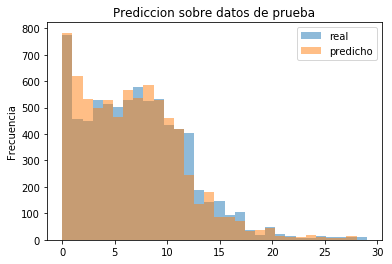

In [270]:
validacion_resultados(modelo_rf, X_dev, y_dev)

### XGB

In [262]:
modelo_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocesa',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=False,
                                                                                  with_std=False))],
                                                           verbose=False),
                                                  ['rezago_1_est1',
                                                   'rezago_1_est2',
                                                   'r

############Validación cruzada#######################
R2: 0.578 (+/- 0.310)
scores R2: [-0.03833695  0.77125953  0.77124792  0.67325309  0.71269917]
####################################################
RMSE (redondeando y): 1.58
R2 (redondeando y): 0.90


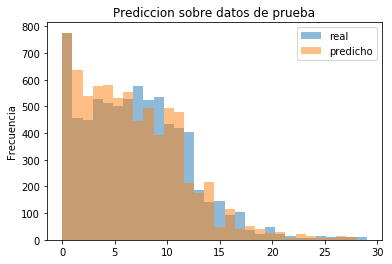

In [263]:
validacion_resultados(modelo_xgb, X_dev, y_dev)

## GridSearch

In [250]:
tscv = TimeSeriesSplit(n_splits=3)
params = {
    'reg__n_estimators':(50, 70, 100),
    'reg__min_samples_split':(5, 10),
}
finder = GridSearchCV(
    estimator=modelo_rf,
    param_grid=params,
    scoring='r2',
    n_jobs=4,
    iid=False,
    cv=tscv,  # change this to the splitter subject to test
    verbose=1,
    error_score=-999,
    return_train_score=True
)

In [251]:
finder.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed: 24.1min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=-999,
             estimator=Pipeline(memory=None,
                                steps=[('preprocesa',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                      

In [253]:
finder.best_params_

{'reg__min_samples_split': 10, 'reg__n_estimators': 100}

############Validación cruzada#######################
R2: 0.812 (+/- 0.165)
scores R2: [0.483367   0.88278294 0.87593631 0.89609355 0.92251651]
####################################################
RMSE (redondeando y): 1.41
R2 (redondeando y): 0.92


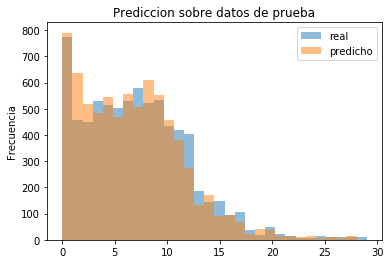

In [272]:
mejor_rf = finder.best_estimator_
validacion_resultados(mejor_rf, X_dev, y_dev)

## Guardando modelo 

In [274]:
dump(modelo_rf, '../modelos/modelo_predictor_bikes.joblib') 

['../modelos/modelo_predictor_bikes.joblib']

# Modelo de predicción de estatus de la estación

## Datos

In [5]:
estaciones = [1, 2, 3, 4, 5]
df = pd.read_csv(dir_datos+'uso_estaciones_20191016.csv')\
    .drop('Unnamed: 0', axis=1)\
    .query('5<=hora<=23')\
    #.query('id==@estaciones')

# estatus = 1: sin bicicletas, 2: Entre 1 y 5, 3: más de 5
df['estatus'] = 3
df.loc[lambda x: x['bikes']==0, 'estatus'] = 1
df.loc[lambda x: (1<=x['bikes']) & (x['bikes']<=5), 'estatus'] = 2

x_vars = ['nombre_dia', 'id', 'fracc_dia', 'fecha_dt'] 
y_var = ['estatus']
XY = df[x_vars+y_var].copy()
#estatus = X.pop('estatus')
fecha_corte1 = "2019-09-29"
fecha_corte2 = "2019-10-06"
X_train = XY.query('fecha_dt<=@fecha_corte1')
X_dev = XY.query('@fecha_corte1<fecha_dt<=@fecha_corte2')
X_test = XY.query('fecha_dt>@fecha_corte2')

y_train = X_train.pop('estatus')
y_dev = X_dev.pop('estatus')
y_test = X_test.pop('estatus')

X_train.head()

,nombre_dia,id,fracc_dia,fecha_dt
0,jueves,1,161,2019-08-22 13:25:00
1,jueves,2,161,2019-08-22 13:25:00
2,jueves,3,161,2019-08-22 13:25:00
3,jueves,4,161,2019-08-22 13:25:00
4,jueves,5,161,2019-08-22 13:25:00


## Preprocesamiento

In [6]:
categorical_features = ['nombre_dia', 'id', 'fracc_dia']

# Crea una variable dummy por cada categoría para cada variable categórica
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore')),
                                   ])

preprocesa = ColumnTransformer([
        ('cat', categorical_transformer, categorical_features)],
        remainder='drop')

## Estimación

### RandomForest

In [23]:
clf_rf = Pipeline([('preprocesa', preprocesa),
                      ('clf', RandomForestClassifier(n_estimators=5, max_depth=100, n_jobs=2))])

clf_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocesa',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('onehot',
                                                                   OneHotEncoder(categorical_features=None,
                                                                                 categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                       

In [24]:
evaluacion_clasificacion(clf_rf, X_dev, y_dev)

Matriz confusión:
 [[  6532   4738  52175]
 [   697  21059 192466]
 [   590  15727 467776]]
Exactitud (macro):  65.03%
Precisión (macro):  66.64% ([0.83540095 0.50715249 0.65660421])
Exhaustividad (macro):  38.92% ([0.10295532 0.09830456 0.96629367])
F1 score (macro):  37.66% ([0.18331837 0.16468684 0.78190069])


### XGB

In [47]:
clf_xgb = Pipeline([('preprocesa', preprocesa),
                      ('clf', xgb.XGBClassifier(objective="multi:softmax", max_depth=100, num_class=3,
                                                random_state=42, n_jobs=-1))])
clf_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocesa',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('onehot',
                                                                   OneHotEncoder(categorical_features=None,
                                                                                 categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                       

In [45]:
evaluacion_clasificacion(clf_xgb, X_dev, y_dev)

## Guardando modelo

In [25]:
dump(clf_rf, 'D:/datos/ecobici/modelos/modelo_predictor_estatus.joblib') 

['D:/datos/ecobici/modelos/modelo_predictor_estatus.joblib']

## consultando el modelo

In [17]:
df.memory_usage(deep=True).sum()/2**20

2563.2296810150146

In [5]:
clases = {1: 'No hay bicicletas disponibles', 2: 'Menos de 5 bicicletas', 3: 'Más de 5 bicicletas'}
clf_rf = load('d:/datos/ecobici/modelos/modelo_predictor_estatus.joblib')

In [25]:
opciones_dia = ['lunes', 'martes', 'miercoles', 'jueves', 'viernes', 'sábado', 'domingo']
id_estaciones = list(range(1, 481))

hora = 8
minuto = 30
punto = dict()
punto['nombre_dia'] = opciones_dia[1]
punto['fracc_dia'] = hora*12 + int(minuto/5)
punto['id'] = id_estaciones
punto['fecha_dt'] = 0

query = pd.DataFrame(punto)[x_vars]
query['estatus'] = clf_rf.predict(query)
query['texto'] = query['estatus'].map(clases)
output = dict()
output['estatus'] = query[['id', 'estatus', 'texto']].to_dict(orient='records')
output['dia'] = dia
output['hora'] = hora
output['minuto'] = minuto

In [30]:
df_graficas = df.loc[df['fecha_dt']>="2019-10-07", ['bikes', 'id', 'nombre_dia', 'hora', 'fecha_dt']]

In [24]:
df_graficas.memory_usage(deep=True).sum()/2**20

177.1875

Text(0.5, 1.0, 'Bicicletas disponibles en la estación 5 a las 19')

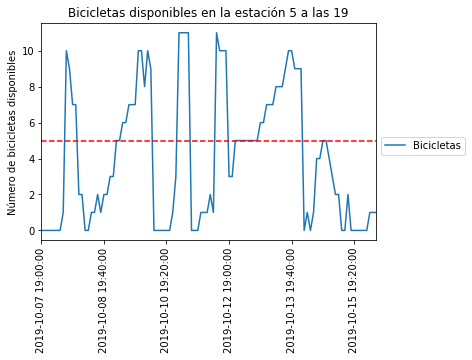

In [34]:
historial = df_graficas.query(f'id=={punto["id"]} & hora=={hora}')\
        .set_index('fecha_dt')
ax = historial.plot(y='bikes', label='Bicicletas', rot=90)
#historial['bikes'].rolling(4).mean().plot(ax=ax, label='media movil 4 días', rot=90)
ax.axhline(y=5, color='red', ls='--')
ax.legend(bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Número de bicicletas disponibles')
ax.set_xlabel('')
ax.set_title(f'Bicicletas disponibles en la estación {punto["id"]} a las {hora}')